# Machine Learning and Pattern Recognition - Project 2

Eleftheria Vrachoriti

# Face Recognition

Start by importing all the libraries that we are going to use later.

In [72]:
import glob
import re
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import random

import matplotlib.pyplot as plt

Mount drive.

In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading images

This function returns the data matrix $X$ of the specified set of images and the labels of each image in the set.

Each image is a line-vector of $X$, because in that way it won't be necessary to calculate $X^{T}$ for PCA, which is time consuming.
<br> </br>

All $50 \times 50$ pixel images are black and white, meaning they are two-dimensional and can be converted to $2500$-element line-vectors.
<br> </br>

The data matrix $X$ is formed by all line-vectors.

In [74]:
def loadImages(path, set_number):
  """
  Returns a data matrix X of the specified set of images and the labels of each image in the set.
  path: path in which the images are stored.
  set_number: number of set of images.
  """
  paths = glob.glob(path + '/set_' + str(set_number) + '/*.png')
  # read image in grayscale, convert and reshape it to column-vector and add it to a list
  images = [(np.array(cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE))).reshape(-1) for path in paths]

  # convert list of column-vectors to np array and standardize each image
  images = np.stack(images, axis=0)
  labels = [int(re.findall(r'\d+', path)[1]) for path in paths]
  return (images, labels)

## Standarization

Standardize each image according to the following formula:

$ \begin{aligned}
  \mathbf{x}' = \frac{\mathbf{x} - μ}{σ}&&
\end{aligned} $, where

$\mathbf{x}$: image column-vector

$μ$: mean of $\mathbf{x}$

$σ$: standard deviation of $\mathbf{x}$

In [75]:
def standardizeImages(images):
  mean = np.mean(images, axis=0)
  std = np.std(images, axis=0)
  images = [(image - mean)/std for image in images]
  return (np.stack(images, axis = 0), mean, std)

Standardization is used to scale data so that $μ = 0$ and $σ = 1$.
<br> </br>

This is used to avoid bias and overfitting.

## Eigenfaces

Load train and test set and standardize data.



In [76]:
(train_set, train_labels) = loadImages("/content/gdrive/MyDrive/faces", 1)
std_train_set, mean, std = standardizeImages(train_set)

test_sets = []
std_test_sets = []
test_labels = []
test_avg_std = []
for i in range(1, 6):
  test_set, test_label = loadImages("/content/gdrive/MyDrive/faces", i)
  test_sets.append(test_set)
  test_labels.append(test_label)
  std_test_set, mean, std = standardizeImages(test_set)
  std_test_sets.append(std_test_set)
  test_avg_std.append((mean, std))

## PCA and top eigenvectors

Train model using PCA (or Karhunen-Loeve method).
<br></br>

The PCA class has been implemented below, so that we can corectly compare the results of PCA and SVD in the respective section,  because sklearn implementation of PCA uses SVD.

In [93]:
class PCAimp():
  def __init__(self, n_components):
    self.n_components = n_components

  def fit(self, train_set):
    C = np.cov(std_train_set, rowvar=False)
    C_eigen_values, C_eigen_vectors = np.linalg.eigh(C)
    sorted_indices = np.argsort(C_eigen_values)[::-1]
    C_eigen_values = C_eigen_values[sorted_indices]
    C_eigen_vectors = C_eigen_vectors[:, sorted_indices]
    (rows, columns) = C_eigen_vectors.shape
    self.components_ = C_eigen_vectors[:, :self.n_components]
    return self.components_

  def transform(self, train_set):
    return np.dot(train_set, self.components_)

  def fit_transform(self, train_set):
    self.fit(train_set)
    return self.transform(train_set)

  def inverse_transform(self, train_set):
    return np.dot(train_set, np.transpose(self.components_))

  def components(self):
    return self.components_

The following function calculates the eigenfaces.

In [94]:
def eigenfaces_cov(train_set, test_sets, d, std=True):
  if not std:
    train_set = standardizeImages(train_set)
    test_sets = [standardizeImages(test_set) for test_set in test_sets]
  pca_imp = PCAimp(n_components=d)
  train_pca_imp = pca_imp.fit_transform(std_train_set)

  knn = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
  knn.fit(train_pca_imp, train_labels)

  print("d =", d)
  for i, std_test_set in enumerate(std_test_sets):
    test_pca_imp = pca_imp.transform(std_test_set)
    knn_test_labels = knn.predict(test_pca_imp)
    print("Set", i + 1, ": accuracy =", accuracy_score(test_labels[i], knn_test_labels)*100)
  print()
  return pca_imp

Test eigenfaces implementation for $d = 9$ and $d = 30$ and measure accuracy score for each Set.

In [95]:
pca_d9_cov = eigenfaces_cov(std_train_set, std_test_sets, d=9)
pca_d30_cov = eigenfaces_cov(std_train_set, std_test_sets, d=30)

d = 9
Set 1 : accuracy = 100.0
Set 2 : accuracy = 91.66666666666666
Set 3 : accuracy = 72.5
Set 4 : accuracy = 30.0
Set 5 : accuracy = 18.421052631578945

d = 30
Set 1 : accuracy = 100.0
Set 2 : accuracy = 96.66666666666667
Set 3 : accuracy = 85.83333333333333
Set 4 : accuracy = 42.857142857142854
Set 5 : accuracy = 21.052631578947366



The generalization of a model can be measured by testing our model on test sets, which have different samples than the train set.
<br></br>

Using $d = 9$ yields very accurate results, which is quite impressive.
This confirms that any set of black and white images under different lightning conditions can be characterized as a 9-dimensional subspace, as Basri and Jacobs stated in 1987. [[1]](#reference)

Using $d = 30$ yields more accurate results than $d = 9$.
The reason behind this, is that a larger value of $d$ (the number of features) leads to more information for each sample, which has the potential to increase the generalization of the model.
<br></br>

The following conclusions have been made for both values of $d$.

The highest accuracy is observed in **Set 1**, as expected, because it was used to train our model.

For the rest of the sets and for both values of, the accuracy is decreasing and the lowest accuracy is observed in **Set 5**.
This is probably, because the pictures of **Set 5** are the darkest, meaning they are the most different to the ones used for training the model and thus, the model is least capable of generalization.

As Sirovich and Kirby stated in 2003 [[2]](#reference), any face can be represented by a set of eigenvectors.

The eigenvectors are the principal components of the $d$-dimensional subspace and can be combined linearly in order to reconstruct estimations of faces that will be similar to the initial ones.

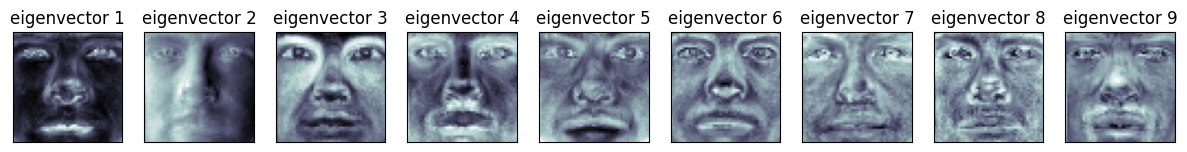

In [96]:
C = np.cov(std_train_set, rowvar=False)

C_eigen_values, C_eigen_vectors = np.linalg.eigh(C)
sorted_indices = np.argsort(C_eigen_values)[::-1]
C_eigen_values = C_eigen_values[sorted_indices]
C_eigen_vectors = C_eigen_vectors[:, sorted_indices]
(rows, columns) = C_eigen_vectors.shape

plt.figure(figsize=(15, 10))
for i in range(0, 9):
  plt.subplot(1, 9, i + 1)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(C_eigen_vectors[:, i].reshape(50, 50), cmap='bone')
  plt.title("eigenvector %d" %(i + 1))

## Face reconstruction

Apply inverse transform to get an approximation of the original data.
<br></br>

Reconstruct a random image of each Set.

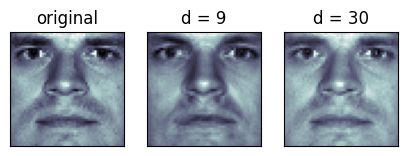

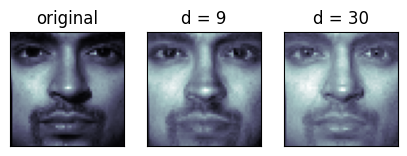

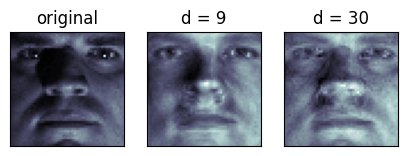

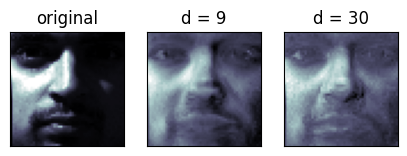

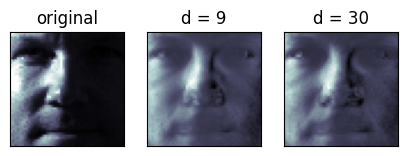

In [97]:
for i in range(0, 5):
  test_set = test_sets[i]
  std_test_set = std_test_sets[i]
  (rows, columns) = std_test_set.shape
  index = random.randint(0, rows - 1)
  mean, std = test_avg_std[i]
  plt.figure(figsize=(5, 5))
  plt.subplot(1, 3, 1)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow((test_set[index, :]).reshape(50, 50), cmap='bone')
  plt.title("original")
  inverse_d9 = pca_d9_cov.inverse_transform(pca_d9_cov.transform(std_test_set[index].reshape(1, -1))) * std + mean
  inverse_d30 = pca_d30_cov.inverse_transform(pca_d30_cov.transform(std_test_set[index].reshape(1, -1))) * std + mean
  plt.subplot(1, 3, 2)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(inverse_d9.reshape(50, 50), cmap='bone')
  plt.title("d = 9")
  plt.subplot(1, 3, 3)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(inverse_d30.reshape(50, 50), cmap='bone')
  plt.title("d = 30")

The reconstructed faces are very similar for the two values of $d$, but the ones with $d=30$ are a bit more detailed, probably because of the more information held for each sample, as mentioned in the previous sections.
<br></br>

The reconstructed faces of the first set is very close to the original image.

The reconstructed faces of the next two sets are still close to the original images, but brighter and a little more blurry.

The reconstructed faces of the last two sets are much brighter version of the original images, almost like any shadows in the original images are removed, but they have lost a lot of sharpness, making the characteristics of the face much less distinct.

## Singular vectors

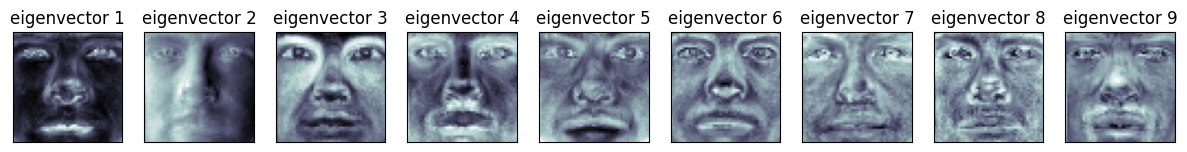

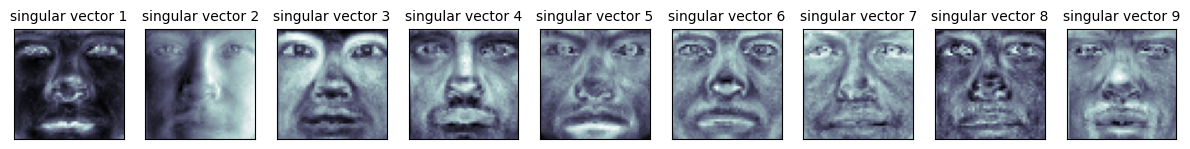

In [82]:
U, s, Vtranspose = np.linalg.svd(std_train_set, full_matrices=False)
# s contains singular values in descending order

plt.figure(figsize=(15, 10))
for i in range(0, 9):
  plt.subplot(1, 9, i + 1)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(C_eigen_vectors[:, i].reshape(50, 50), cmap='bone')
  plt.title("eigenvector %d" %(i + 1))

plt.figure(figsize=(15, 10))
for i in range(0, 9):
  plt.subplot(1, 9, i + 1)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.imshow(Vtranspose[i, :].reshape(50, 50), cmap='bone')
  plt.title("singular vector %d" %(i + 1), fontdict={'fontsize' : 10})

The eigenvectors are almost identical to the singular vectors, because both PCA and SVD methods perform a decomposition of the correlation matrix $C$.

Differencies between them are probably due to numerical errors that may occur during matrix multiplications, which can negatively affect the final results.

# MNIST - SVMs

Start by importing all the libraries that we are going to use later.

In [57]:
from keras.datasets import mnist
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC, SVC
import pandas as pd
import time

## Loading dataset

Load MNIST dataset and divide it into training and test set.

All $28 \times 28$ pixel images are black and white, meaning they are two-dimensional and can be converted to $784$-element line-vectors.
<br> </br>

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.swapaxes(1, 2).reshape(60000, -1) # convert tensor to 2d-array
x_test  = x_test.swapaxes(1, 2).reshape(10000, -1)

## Normalization

Normalize each image, so that all its pixels are in $[0, 1]$.

In [49]:
x_train = Normalizer().transform(x_train)
x_test = Normalizer().transform(x_test)

## Hyperparameter optimization

We are going to measure the accuracy of SVMs with linear and rbf kernel and different values of hyperparameters $C$ and $\gamma$.

### SVM with linear kernel

We can use the <code>GridSearchCV</code> method for cross validation with $5$ folds.

Tests are done for the following values of hyperparameter $C$: $0.01$, $0.1$ and $1$.
<br></br>

The test results are stored in a <code>pandas DataFrame</code> and can be found below.

In [5]:
C = [0.01, 0.1, 1.0]

k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_grid_linear = {"C": C}
linear_svm = LinearSVC(dual=False)
linear_svm_cv = GridSearchCV(linear_svm, param_grid_linear, scoring='accuracy', cv=k_folds, return_train_score=True)

In [ ]:
%%time
param_grid_linear = {"C": C}
linear_svm_cv.fit(x_train, y_train)

linear_cv_df = pd.DataFrame(linear_svm_cv.cv_results_)
temp_df = linear_cv_df[['mean_fit_time', 'param_C', 'mean_train_score', 'mean_test_score']]
temp_df

CPU times: user 4min 33s, sys: 4.83 s, total: 4min 38s
Wall time: 4min 42s


,mean_fit_time,param_C,mean_train_score,mean_test_score
0,12.658330,0.01,0.888521,0.886767
1,15.901459,0.1,0.912700,0.908517
2,21.573664,1.0,0.923525,0.915117


Measure accuracy on test set for the best value of hyperparameter $C$.

In [ ]:
%%time
test_labels = linear_svm_cv.predict(x_test)
test_acc = accuracy_score(y_test, test_labels)*100
print("Test  accuracy score :", test_acc)

Test  accuracy score : 92.14
CPU times: user 80.2 ms, sys: 5.95 ms, total: 86.1 ms
Wall time: 60.5 ms


### SVM with RBF kernel

<code>GridSearchCV</code> fails even for three different values of $C$ and $\gamma$, as the execution time exceeds the execution time granted by Google Colab.
<br></br>

Values for $C$ and $\gamma$ between $10^{-3}$ and $10^{3}$ are sufficient. [[3]](#reference)

Tests are done for the following values of hyperparameter $C$: $0.01$, $0.1$ and $1$ and $\gamma$: <code>'scale'</code>, $0.1$.
<br></br>

The test results are stored in a table table can be found below.

In [7]:
def train_rbf_svm(C, gamma):
  print("C =", C, "gamma =", gamma)
  model = SVC(kernel='rbf', C=C, gamma=gamma)
  model.fit(x_train, y_train)
  train_labels = model.predict(x_train)
  train_acc = accuracy_score(y_train, train_labels)*100
  print("Train accuracy score :", train_acc)
  test_labels = model.predict(x_test)
  test_acc = accuracy_score(y_test, test_labels)*100
  print("Test  accuracy score :", test_acc)

In [ ]:
%%time
train_rbf_svm(0.01, 'scale')

C = 0.01 gamma = scale
Train accuracy score : 92.325
Test  accuracy score : 92.80000000000001
CPU times: user 1h 21min 44s, sys: 14.7 s, total: 1h 21min 59s
Wall time: 1h 22min 8s


In [ ]:
%%time
train_rbf_svm(0.1, 'scale')

C = 0.1 gamma = scale
Train accuracy score : 96.43833333333333
Test  accuracy score : 96.14
CPU times: user 36min 7s, sys: 6.73 s, total: 36min 14s
Wall time: 36min 22s


In [ ]:
%%time
train_rbf_svm(1, 'scale')

C = 1 gamma = scale
Train accuracy score : 99.12666666666667
Test  accuracy score : 98.11
CPU times: user 18min 58s, sys: 2.21 s, total: 19min
Wall time: 19min 9s


In [ ]:
%%time
train_rbf_svm(0.01, 0.1)

C = 0.01 gamma = 0.1
Train accuracy score : 83.31833333333334
Test  accuracy score : 84.26
CPU times: user 2h 3min 38s, sys: 14 s, total: 2h 3min 52s
Wall time: 2h 4min 7s


In [8]:
%%time
train_rbf_svm(0.1, 0.1)

C = 0.1 gamma = 0.1
Train accuracy score : 91.55
Test  accuracy score : 92.11
CPU times: user 49min, sys: 8.43 s, total: 49min 8s
Wall time: 49min 14s


In [9]:
%%time
train_rbf_svm(1, 0.1)

C = 1 gamma = 0.1
Train accuracy score : 94.465
Test  accuracy score : 94.51
CPU times: user 23min 16s, sys: 3.8 s, total: 23min 20s
Wall time: 23min 19s


SVM with RBF kernel test results

|$C$ |$\gamma$|Train accuracy score (%)|Test accuracy score (%)|Time (total)|
|:--:|:------:|:----------------------:|:---------------------:|:----------:|
|0.01 |'scale'    |92.325              |92.80                  |1h 21min    |
|0.1  |'scale'    |96.43               |96.14                  |0h 36min    |
|**1**|**'scale'**|**99.43**           |**98.11**              |**0h 19min**|
|0.01 |0.1        |83.31               |84.26                  |2h 4min     |
|0.1  |0.1        |91.55               |92.11                  |0h 49min    |
|1    |0.1        |94.465              |94.51                  |0h 23min    |

If the value of $C$ is low, the model takes longer to make predictions, due to the increasing number of support vectors.
<br></br>

If the value of $\gamma$ is low, the model cannot fit the data properly, because it will take much farther points into consideration.

On the other hand, a large value of $\gamma$ may lead to overfitting, due to the fact that only points that are close to the support vectors are considered. [[3]](#reference)
<br></br>

The highest test accuracy score is achieved for the RBF kernel and the following hypeparameter values:

$C = 1$, $\gamma = $ <code>'scale'</code>

## PCA

We can apply PCA on the dataset to reduce the number of components, which is respective to the explained variance.

In most applications, the explained variance has a value between $80\%$ and $90\%$.
<br></br>

After applying PCA, we can train our SVM model with the hyperparameter values that were obtained in the previous section, $C = 1$, $\gamma = $ <code>'scale'</code>.

In [61]:
def pca_svm_test(x_train, y_train, x_test, y_test, C, gamma, explained_variance):
  print("Explained variance  :", explained_variance)
  X = np.concatenate((x_train, x_test), axis=0)
  pca = PCA(n_components=explained_variance, svd_solver='full').fit(X)
  x_pca = pca.transform(X)
  x_train_pca, x_test_pca = x_pca[:60000], x_pca[60000:]

  n_components = pca.n_components_
  cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
  print("Number of components:", n_components)

  # train SVM model
  model = SVC(kernel='rbf', C=C, gamma=gamma)
  model.fit(x_train_pca, y_train)
  test_labels = model.predict(x_test_pca)
  test_acc = accuracy_score(y_test, test_labels)*100
  print("Test  accuracy score:", test_acc)

  return (n_components, test_acc)

In [64]:
variances = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9]

figure_x = []
figure_y = []
print("C = 1, gamma = 'scale'")
for var in variances:
  t0 = time.time()
  n_components, test_acc = pca_svm_test(x_train, y_train, x_test, y_test, 1, 'scale', var)
  t1 = time.time()
  print("Time: %.2f" % (t1 - t0), "sec")
  print()
  figure_x.append(n_components)
  figure_y.append(test_acc)

C = 1, gamma = 'scale'
Explained variance  : 0.8
Number of components: 48
Test  accuracy score: 98.46000000000001
Time: 70.30 sec

Explained variance  : 0.82
Number of components: 53
Test  accuracy score: 98.5
Time: 69.62 sec

Explained variance  : 0.84
Number of components: 60
Test  accuracy score: 98.52
Time: 84.03 sec

Explained variance  : 0.86
Number of components: 69
Test  accuracy score: 98.52
Time: 91.87 sec

Explained variance  : 0.88
Number of components: 79
Test  accuracy score: 98.48
Time: 93.63 sec

Explained variance  : 0.9
Number of components: 93
Test  accuracy score: 98.49
Time: 99.33 sec



Create plot that shows how the number of components is related to the test accuracy score.

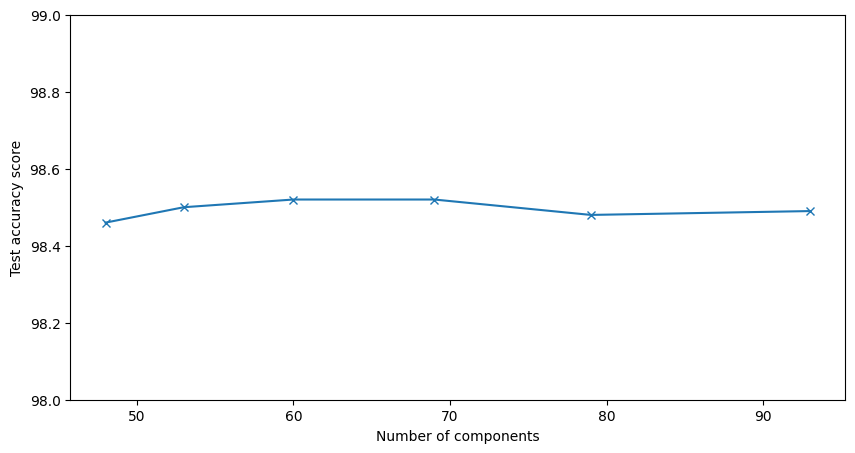

In [71]:
plt.figure(figsize=(10, 5))
plt.ylim((98, 99))
plt.xlabel('Number of components')
plt.ylabel('Test accuracy score')
plt.plot(figure_x, figure_y, marker="x")

## Conclusions
<br>Even for a small number of components, the accuracy score is greater than $98\%$.</br>
<br></br>

Our goal is to reduce the number of dimensions, in order to reduce the execution time, while also keeping the most of information in our data.

There is a trade-off between test accuracy score, execution time and the number of components.
<br></br>

Increasing the number of components leads to a higher number of computations and thus, execution time.

This can be seen in the tests made in the previous sections.
<br></br>

Increasing the number of components leads to representations of the data that are closer to its original form, which also increases the explained variance and thus, a higher test accuracy score is achieved in most cases.
<br></br>

# References

[1] Sirovich, Lawrence & Kirby, M. (1987). Low-dimensional Procedure for the Characterization of Human Faces. Journal of the Optical Society of America. A, Optics and image science. 4. 519-24. 10. 1364/JOSAA.4.000519.

[2] Basri, Ronen & Jacobs, D.W. (2003). Lambertian reflectance and linear subspaces. Pattern analysis and Machine Intelligence, IEEE Transactions on. 25. 218-233. 10.1109/TPAMI.2003.1177153.

[3] sklearn, RBF SVM parameters, https://scikit-learn-org/stable/auto_examples/svm/plot_rbf_parameters.html